In [ ]:
from weaPoints import WeaPoints, WindDataType, CalculationMethod
import numpy as np
import xarray
import pandas

from global_setup import _CONN_PARAMS_DIC
from databaseLoad import read_postgres_from_queryfile, _create_postgres_engine
import plotly.express as px
import matplotlib.pyplot as plt

import geopandas as gpd
import contextily as cx
import math

# Set Limit for displaying columns to None
pandas.set_option('max_columns', None)

# Path to sql query files
sql_path = "/home/eouser/Documents/code/Windatlas/windatlas/mastr/sqlCommands/"
sql_data = "loadMastrWind.sql"

sql_data_path = sql_path + sql_data

In [ ]:
bundesländer = {
    1400:"Brandenburg",
    1401:"Berlin",
    1402:"Baden-Würtenberg",
    1403:"Bayern",
    1404:"Bremen",
    1405:"Hessen",
    1406:"Hamburg",
    1407:"Mecklenburg-Vorpommern",
    1408:"Niedersachsen",
    1409:"Nordrhein-Westfahlen",
    1410:"Rheinland-Pfalz",
    1411:"Schleswig-Holstein",
    1412:"Saarland",
    1413:"Sachsen",
    1414:"Sachsen-Anhalt",
    1415:"Thüringen"}

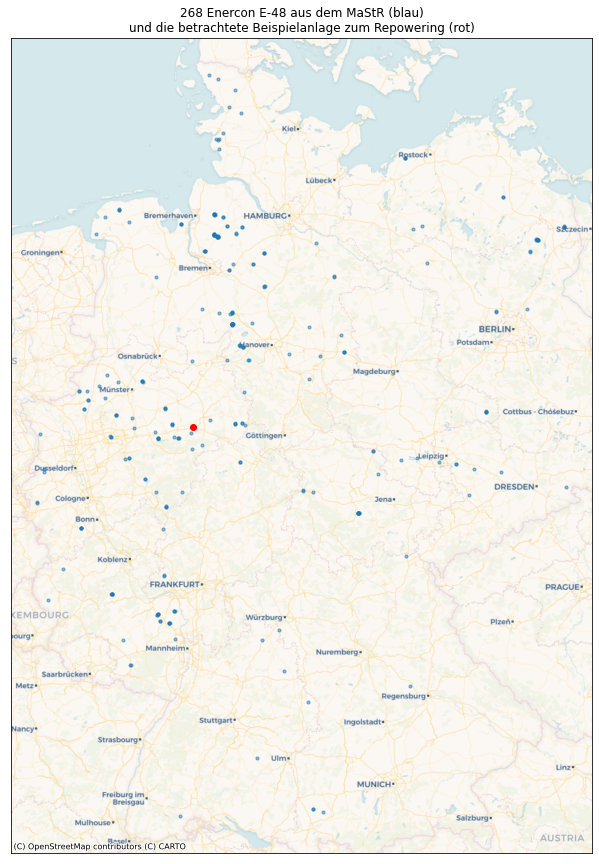

In [17]:
engine = _create_postgres_engine(_CONN_PARAMS_DIC)

query = 'SELECT * FROM mastr_raw."EinheitenWind"' # WHERE "Inbetriebnahmedatum" < "2000-01-01 09:00:00"'

dfMastrWind = gpd.read_postgis(sql=query, con=engine)

dfMastrWind['SpezifischeLeistung'] = (dfMastrWind.Nettonennleistung * 1000) / (math.pi * (dfMastrWind.Rotordurchmesser / 2)**2)
dfMastrWind["Anlagenzahl"] = 1

dfMastrWind = dfMastrWind.replace({"Bundesland": bundesländer})
dfMastrWind

cond_modell = dfMastrWind["Typenbezeichnung"].str.contains("E48|E 48|E-48|e48|e 48|e-48", na=False)
cond_hersteller = dfMastrWind["Hersteller"] == 1586.0

dfrep = dfMastrWind.loc[cond_modell & cond_hersteller,:]
dfrep = dfrep[["EinheitMastrNummer","Inbetriebnahmedatum","Laengengrad","Breitengrad","Nabenhoehe","Bundesland","geom"]].dropna(subset=["Laengengrad","Breitengrad","Nabenhoehe"])
dfrep["Typ"] = "Enercon_E-48"
dfrep = dfrep.loc[dfrep["Laengengrad"]<16,:]

dfrep.crs = "EPSG:4326"
dfrep = dfrep.to_crs(epsg=3857)
ax = dfrep.plot(figsize=(15,15), alpha=.5, markersize=10)
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"{str(dfrep.shape[0])} Enercon E-48 aus dem MaStR (blau)\nund die betrachtete Beispielanlage zum Repowering (rot)")
dfrep.head(n=1).plot(ax=ax, c="r")
fig = ax.get_figure()
#fig.savefig("Repowerung_map.eps", format='eps')
#fig.savefig("Repowerung_map.png", format='png')

In [ ]:
dfMastrWind[["Hersteller", "Nettonennleistung", "Nabenhoehe", "Rotordurchmesser", "Typenbezeichnung", "Inbetriebnahmedatum"]]

In [15]:
dfMastrWind = read_postgres_from_queryfile(
        sql_query_path = sql_data_path,
        db_conn_data = _CONN_PARAMS_DIC
        )

dfMastrWind['SpezifischeLeistung'] = (dfMastrWind.Nettonennleistung * 1000) / (math.pi * (dfMastrWind.Rotordurchmesser / 2)**2)
dfMastrWind["Anlagenzahl"] = 1

dfMastrWind = dfMastrWind.replace({"Bundesland": bundesländer})
dfMastrWind

cond_modell = dfMastrWind["Typenbezeichnung"].str.contains("E48|E 48|E-48|e48|e 48|e-48", na=False)
cond_hersteller = dfMastrWind["Hersteller"] == 1586.0

dfrep = dfMastrWind.loc[cond_modell & cond_hersteller,:]
dfrep = dfrep[["EinheitMastrNummer","Inbetriebnahmedatum","Laengengrad","Breitengrad","Nabenhoehe","Bundesland"]].dropna(subset=["Laengengrad","Breitengrad","Nabenhoehe"])
dfrep["Typ"] = "Enercon_E-48"

In [16]:
dfrep = dfrep.head()

Passed time_frame valid.
TSnetCDF data loaded.
Time period loaded.
Windpower turbine 1 complete
Windpower turbine 2 complete
Windpower turbine 3 complete
Windpower turbine 4 complete
Windpower turbine 5 complete
Windpower turbine 6 complete
Windpower turbine 7 complete
Windpower turbine 8 complete
Windpower turbine 9 complete
Windpower turbine 10 complete
Windpower turbine 11 complete
Windpower turbine 12 complete
Windpower turbine 13 complete
Windpower turbine 14 complete
Windpower turbine 15 complete
Windpower turbine 16 complete
Windpower turbine 17 complete
Windpower turbine 18 complete
Windpower turbine 19 complete
Windpower turbine 20 complete
Windpower turbine 21 complete
Windpower turbine 22 complete
Windpower turbine 23 complete
Windpower turbine 24 complete
Windpower turbine 25 complete
Windpower turbine 26 complete
Windpower turbine 27 complete
Windpower turbine 28 complete
Windpower turbine 29 complete
Windpower turbine 30 complete
Windpower turbine 31 complete
Windpower tu

<AxesSubplot:>

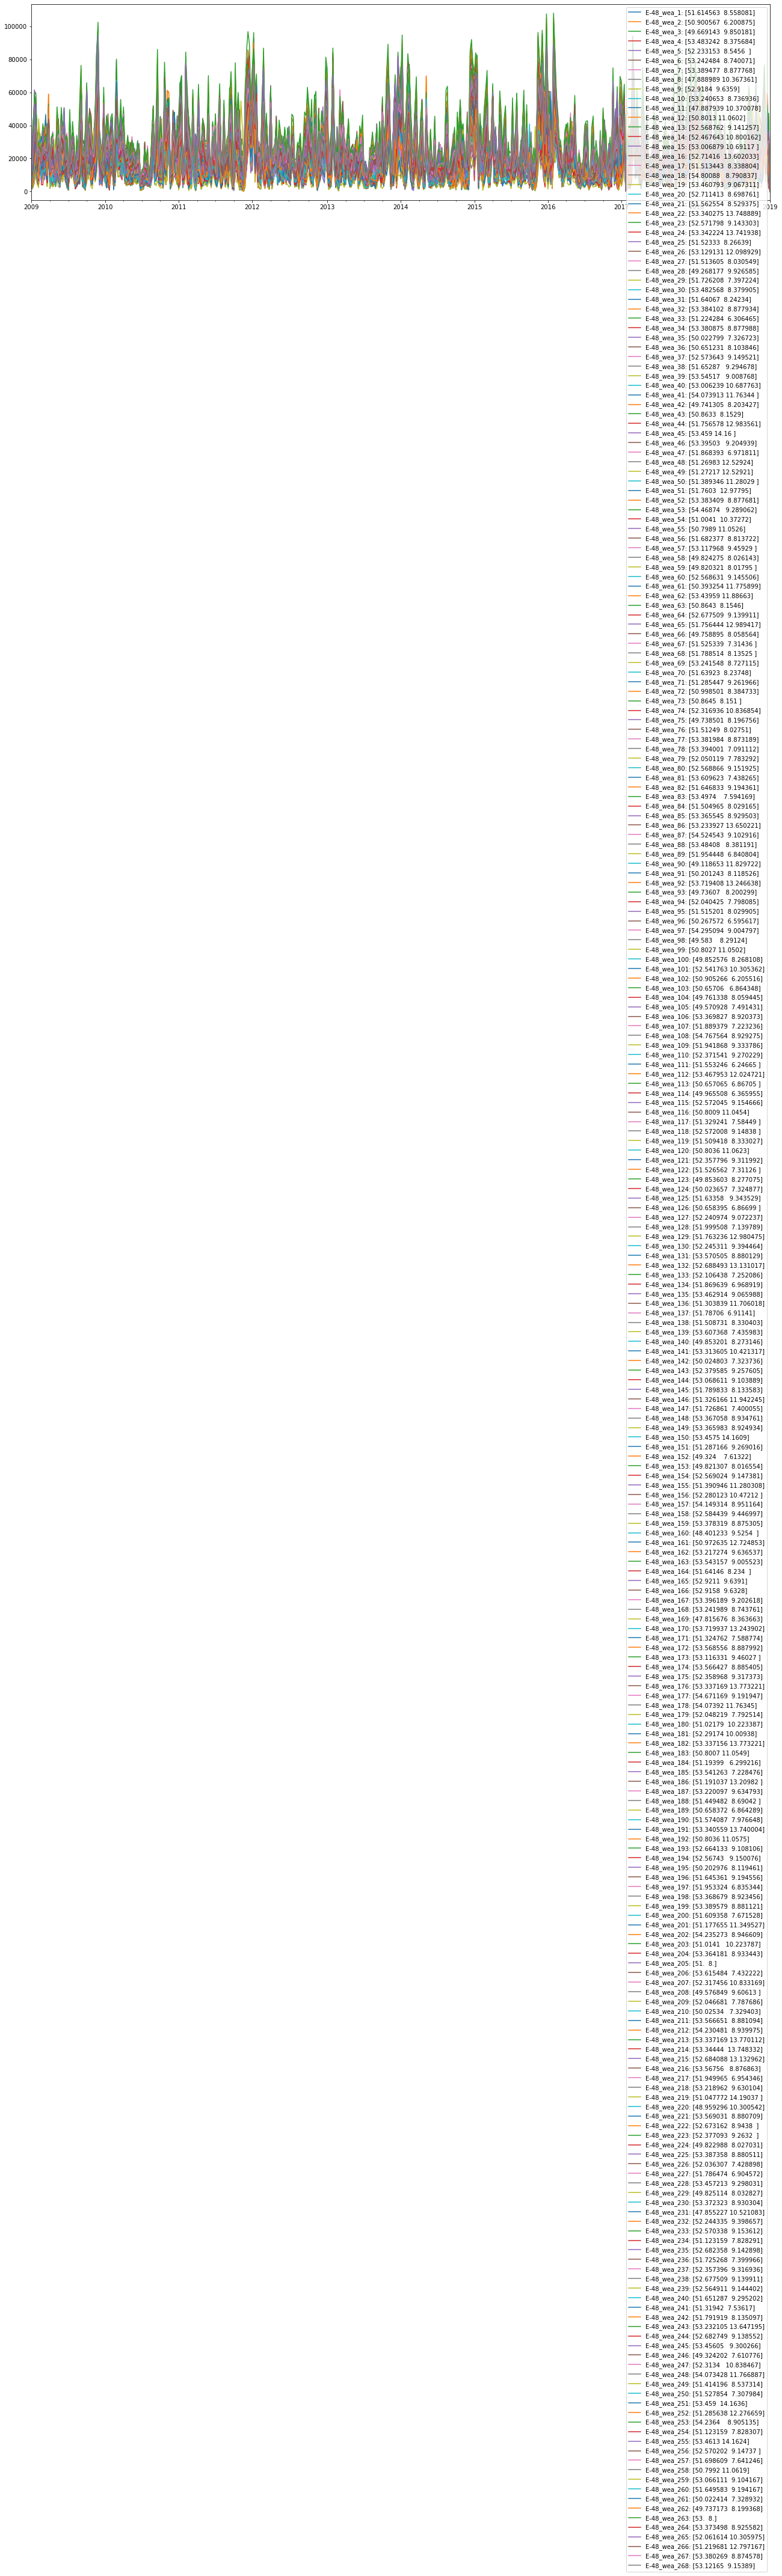

In [18]:
lat_lon_coor = np.stack((dfrep["Breitengrad"].values, dfrep["Laengengrad"].values), axis=1)

e48 = WeaPoints(
    lat_lon_coor = lat_lon_coor,
    level = dfrep["Nabenhoehe"].values,
    wea_types = list(dfrep["Typ"].values),#["WEA_beispiel"] * lat_lon_coor.shape[0],
    #interpolation_method = [InterpolationMethod.LINEAR] * lat_lon_coor.shape[0],
    _interpolated_power_curves = True,
)

e48.get_windpower_out(wind_data_type=WindDataType.TSNETCDF, time_frame=[2009,"2018-12-31"])

Eout = {}
for num, point in enumerate(e48.point_list):
    Eout[f"wea_{num+1}: {point.lat_lon_coor}"] = point.power_time_series

dfe48 = pandas.DataFrame(data=Eout,index=e48.time_periode)
dfe48 = dfe48.add_prefix("E-48_")
dfe48.resample("1w").sum().plot(figsize=(22,6))

In [ ]:
lat_lon_coor = np.stack((dfrep["Breitengrad"].values, dfrep["Laengengrad"].values), axis=1)

e147 = WeaPoints(
    lat_lon_coor = lat_lon_coor,
    level = dfrep["Nabenhoehe"].values,
    wea_types = ["Enercon_E-147_EP5_5.0"] * lat_lon_coor.shape[0],
    #interpolation_method = [InterpolationMethod.LINEAR] * lat_lon_coor.shape[0],
    _interpolated_power_curves = True,
)

e147.get_windpower_out(wind_data_type=WindDataType.TSNETCDF, time_frame=[2009,"2018-12-31"])

Eout = {}
for num, point in enumerate(e147.point_list):
    Eout[f"wea_{num+1}: {point.lat_lon_coor}"] = point.power_time_series

dfe147 = pandas.DataFrame(data=Eout,index=e147.time_periode)
dfe147 = dfe147.add_prefix("E-147_")
dfe147.iloc[:,:5].resample("1w").sum().plot(figsize=(22,6))

## Difference in Power out

In [ ]:
ax = pandas.concat([dfe48, dfe147], axis=1).iloc[:,[0,5]].resample("1h").sum().loc["2016-10":"2017-03",:].plot(figsize=(22,6))

ax.set_title("Vergleich einer Enercon E-48 und E-147 auf Basis eines E-48 Standorts aus dem MaStR")
ax.set_ylabel("Energiertrag [kWh]")
fig = ax.get_figure()
#fig.savefig("Repowerung.eps", format='eps')

In [ ]:
diff = pandas.DataFrame().reindex_like(dfe147)
diff[dfe147.columns] = (dfe147.values / dfe48.values) * 100 # dfe147.values - dfe48.values 
diff.resample("1Y").median()#.plot(figsize=(22,6))

In [ ]:
ger_year = diff.resample("1Y").sum().sum(axis=1) / 1000000000
ger_year = pandas.DataFrame(index = ger_year.index)
ger_year["Difference"] = diff.resample("1Y").sum().sum(axis=1) / 1000000000
ger_year["E-147"] = dfe147.resample("1Y").sum().sum(axis=1) / 1000000000
ger_year["E-48"] = dfe48.resample("1Y").sum().sum(axis=1) / 1000000000
ger_year.to_csv("repowering_E48_E147.csv")

In [ ]:
# Absolut (GWh)
#test = (diff.resample("1Y").sum() / 1000000) * 0.85

# %
test = diff.resample("1Y").median()

x = test.mean().values
y = dfrep["Breitengrad"].values

plt.figure(figsize=(6, 8))
plt.scatter(x,y, s=15, alpha=.6)
plt.xlabel("Repowering-Potential [%]")
plt.ylabel("Breitengrad [°]")
plt.title("Repowering Potential von E-48 zu E-147 nach Breitengrad")
plt.show()

In [ ]:
4000000

In [ ]:
engine = _create_postgres_engine(_CONN_PARAMS_DIC)

query = 'SELECT * FROM mastr_raw."EinheitenWind"' # WHERE "Inbetriebnahmedatum" < "2000-01-01 09:00:00"'

geodf = gpd.read_postgis(sql=query, con=engine)
